# Прогнозирование уровня средней заработной платы в России

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


/Users/serg_pashkov/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#### Визуальный анализ ряда

Построим график изменения заработанной платы до с января 1993 по сентябрь 2018

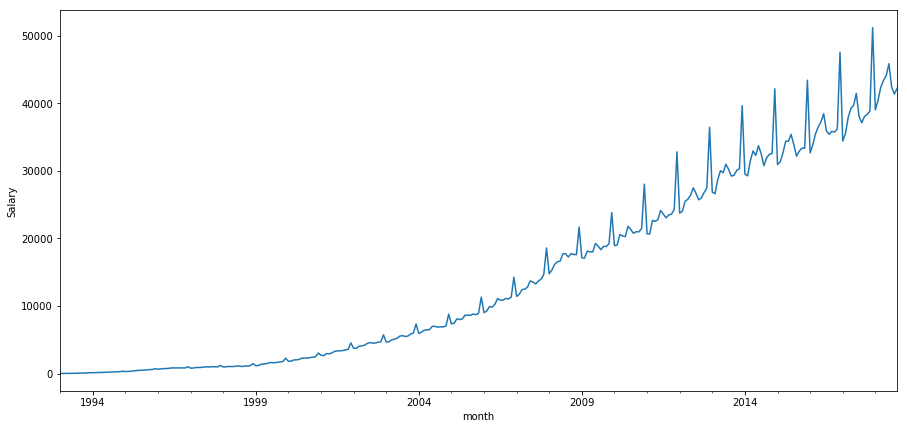

In [28]:
salary = pd.read_csv('../data/WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
plt.figure(figsize(15,7))
salary.WAG_C_M.plot()
plt.ylabel('Salary')
pylab.show()

На графике прослеживается возрастающий тренд, годовая сезонность и значительная разница в дисперсии.

#### Стабилизация дисперсии
Для выравнивания дисперсии сделаем преобразование Бокса-Кокса.

Оптимальный параметр преобразования Бокса-Кокса: 0.280995
Критерий Дики-Фуллера: p=0.726579


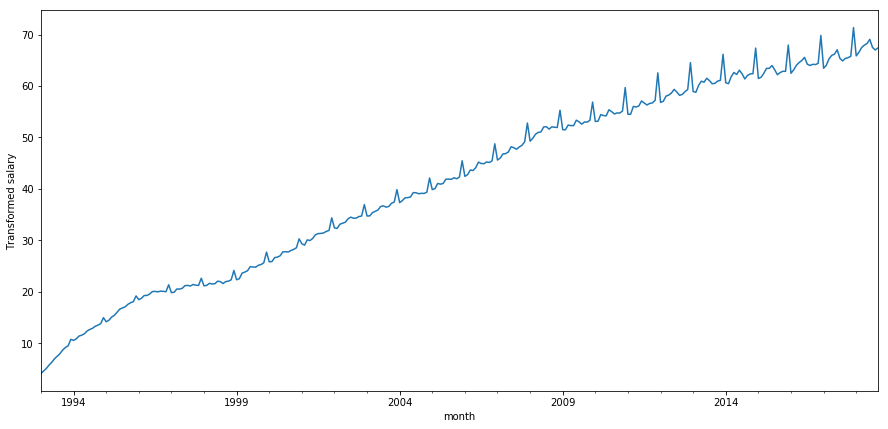

In [29]:
salary['WAG_C_M_box'], lmbda = stats.boxcox(salary.WAG_C_M)
plt.figure(figsize(15,7))
salary.WAG_C_M_box.plot()
plt.ylabel(u'Transformed salary')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M_box)[1])

Ряд нестационарен, т.к. достигаемый уровень значимости критерия Дики-Фуллера > 0.05, а также визуально хорошо просматривается возрастающий тренд.

#### Дифференцирование
Чтобы сделать ряд стационарным выполним сезонное дифференцирование

Критерий Дики-Фуллера: p=0.113099


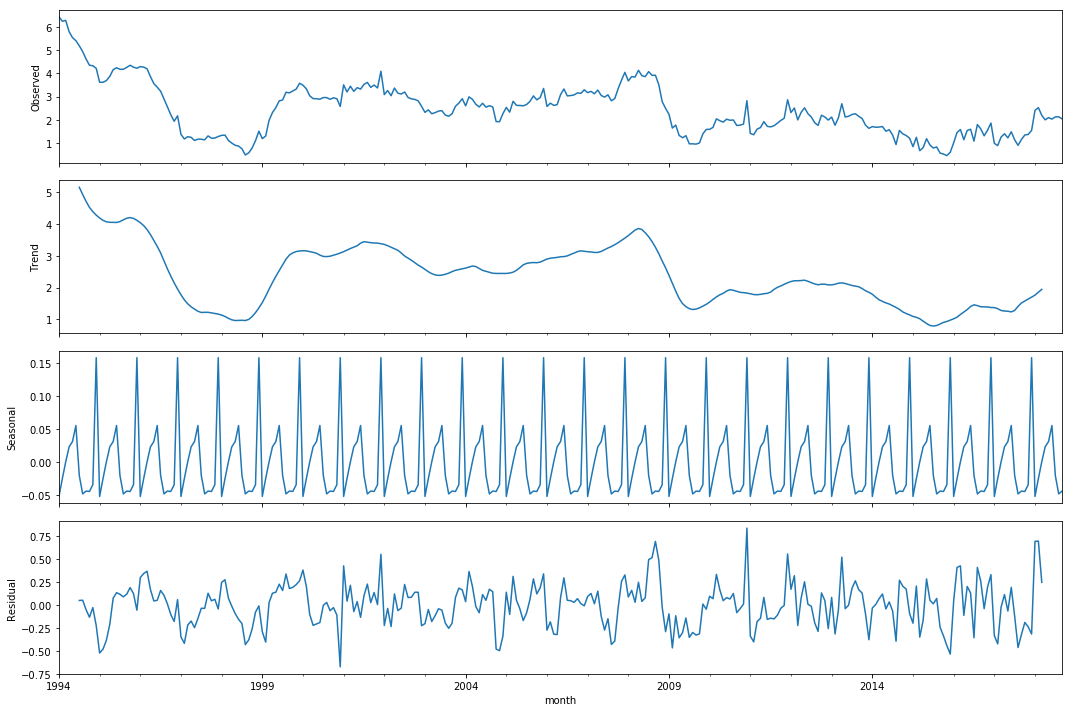

In [30]:
salary['WAG_C_M_box_diff'] = salary.WAG_C_M_box - salary.WAG_C_M_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.WAG_C_M_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M_box_diff[12:])[1])

Ряд все еще нестационарен. Выполним дополнительно обычное дифференцирование.

Критерий Дики-Фуллера: p=2.4981955909818525e-09


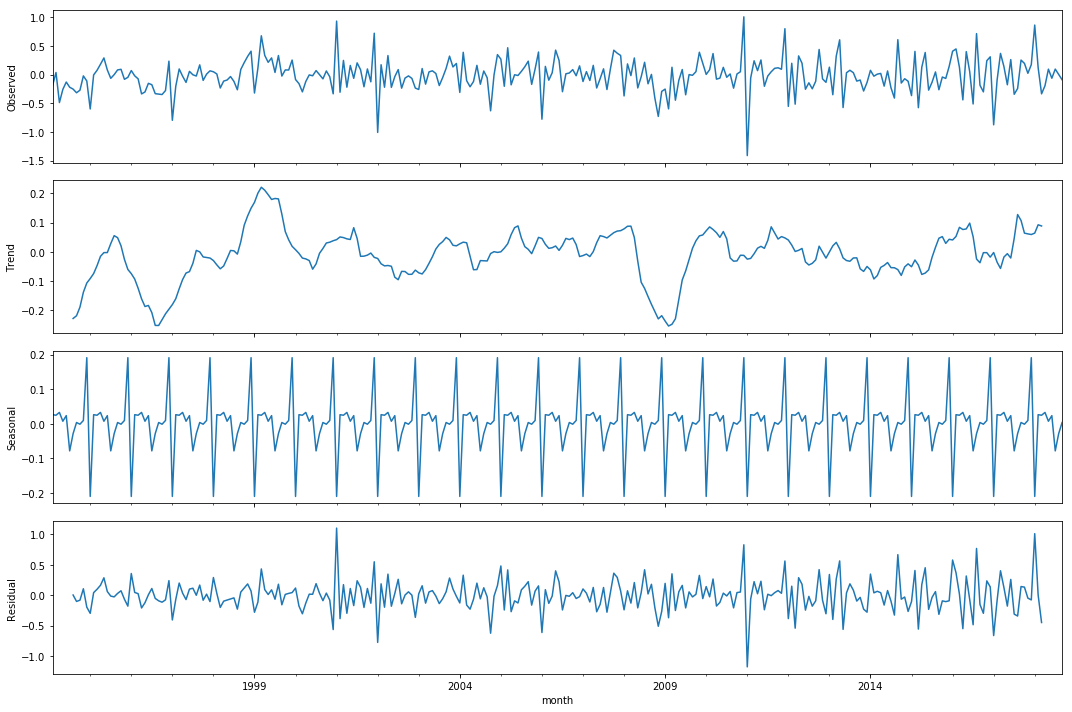

In [31]:
salary['WAG_C_M_box_diff2'] = salary.WAG_C_M_box_diff - salary.WAG_C_M_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.WAG_C_M_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%s" % sm.tsa.stattools.adfuller(salary.WAG_C_M_box_diff2[13:])[1])

Достигаемый уровень значимости меньше 0.05. Тренд визуально не прослеживается. Ряд стационарен.  

#### Выбор начальных приближений для модели ARIMA
Построем графики ACF и PACF

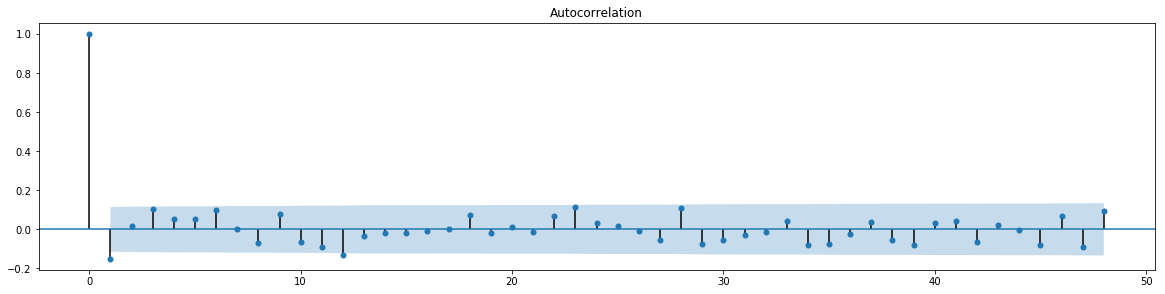

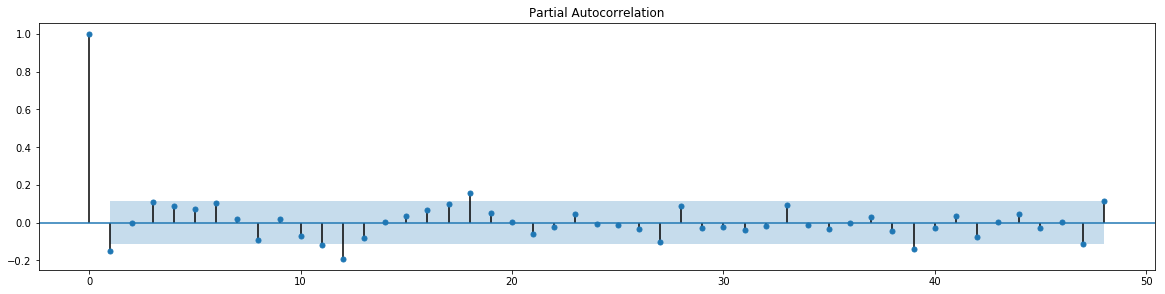

In [32]:
plt.figure(figsize(20,10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=1, q=1, P=1 (также на грани значимости лаг 4, но возьмем 1), p=11 (тоже на грани, но берем)

#### Обучение моделей и выбор лучшей
Сформируем наборы параметров

In [33]:
ps = [0,1,2,3,10,11]
d=1
qs = range(0, 3)
Ps = range(0, 4)
D=1
Qs = range(0, 2)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

144

Обучим модели

In [16]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(salary.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic

    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 0, 1))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 1, 1, 1))
('wrong parameters:', (2, 1, 2, 0))
('wrong parameters:', (2, 1, 2, 1))
('wrong parameters:', (2, 1, 3, 0))
('wrong parameters:', (2, 1, 3, 1))
('wrong parameters:', (3, 2, 0, 0))
('wrong parameters:', (3, 2, 0, 1))
('wrong parameters:', (3, 2, 1, 0))
('wrong parameters:', (3, 2, 1, 1))
('wrong parameters:', (3, 2, 2, 0))
('wrong parameters:', (3, 2, 2, 1))
('wrong parameters:', (3, 2, 3, 0))
('wrong parameters:', (3, 2, 3, 1))
CPU times: user 9min 52s, sys: 13.4 s, total: 10min 6s
Wall time: 5min 32s


Посмотрим топ 5 лучших наборов параметров

In [34]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

        parameters        aic
105  (11, 0, 1, 0)  94.182020
113  (11, 1, 1, 0)  94.449423
104  (11, 0, 0, 1)  95.937696
106  (11, 0, 1, 1)  96.123314
107  (11, 0, 2, 0)  96.133659


Лучшая модель

In [35]:
print(best_model.summary())

                                  Statespace Model Results                                 
Dep. Variable:                         WAG_C_M_box   No. Observations:                  309
Model:             SARIMAX(11, 1, 0)x(1, 1, 0, 12)   Log Likelihood                 -34.091
Date:                             Wed, 31 Oct 2018   AIC                             94.182
Time:                                     22:33:26   BIC                            142.715
Sample:                                 01-01-1993   HQIC                           113.586
                                      - 09-01-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2451      0.044     -5.602      0.000      -0.331      -0.159
ar.L2         -0.0401      

Проанализируем остатки

Критерий Стьюдента: p=0.246251
Критерий Дики-Фуллера: p=0.000000


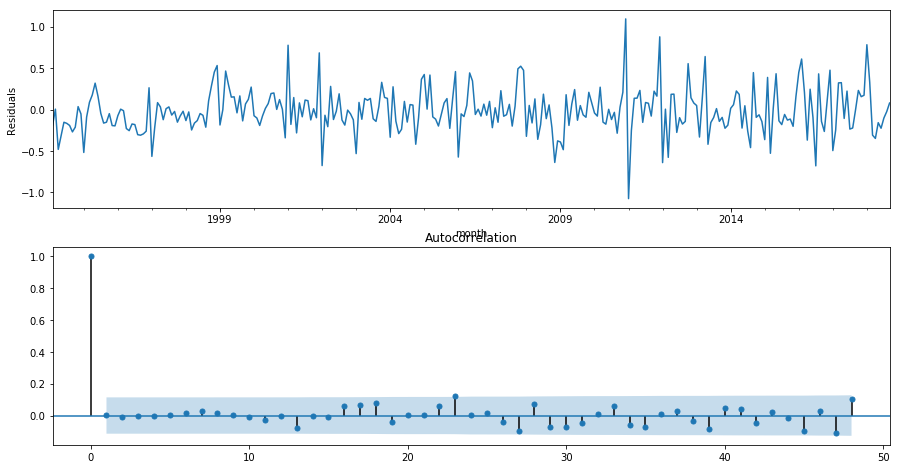

In [36]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Исходя из критериев Стьюдента, Дики-Фуллера и Льюнга-Бокса остатки несмещены, стационарны и неавтокоррелированы. Теперь посмотрим как хорошо модель описывает данные.

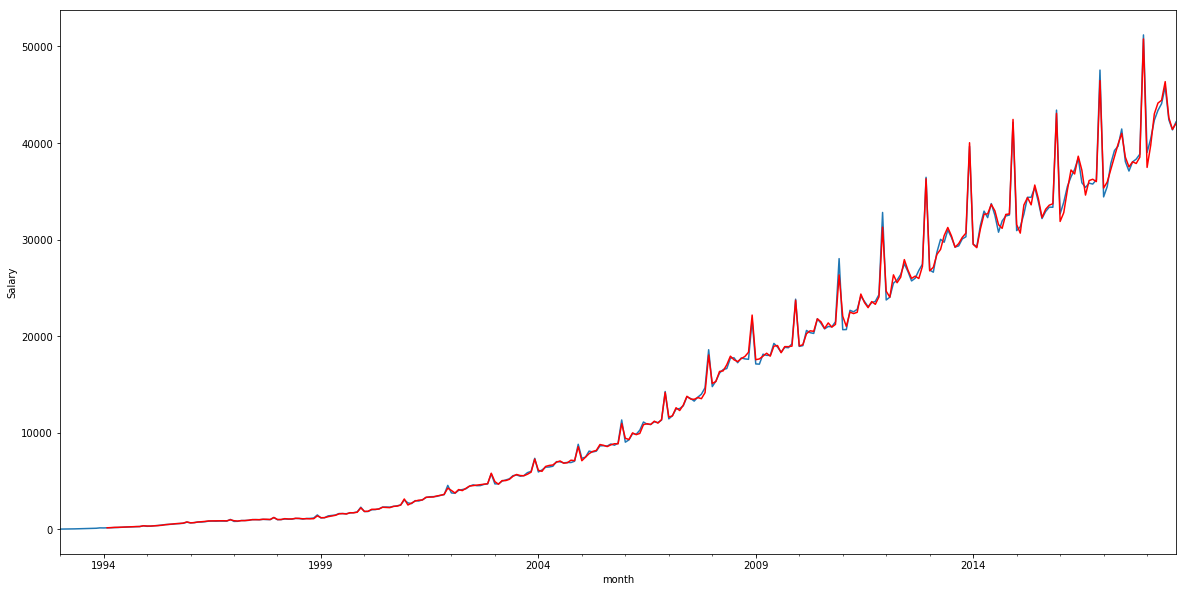

In [37]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(20,10))
salary.WAG_C_M.plot()
salary.model[13:].plot(color='r')
plt.ylabel('Salary')
pylab.show()

Исходя из графика видно, что модель описывает данные достаточно хорошо.

#### Прогноз
Посчитаем прогноз на 2 года вперед

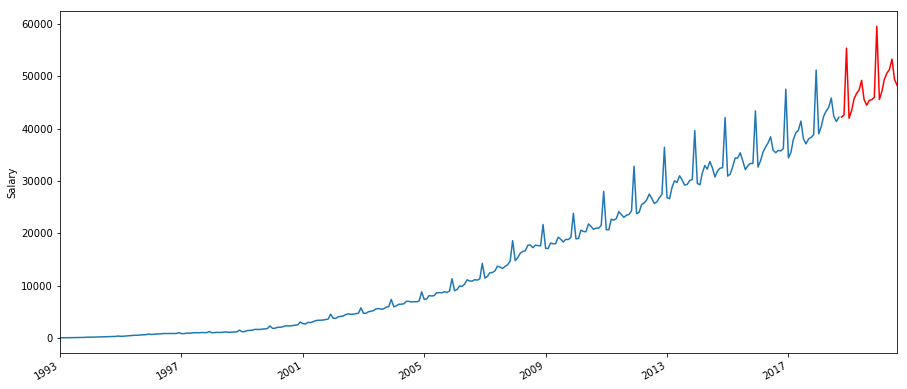

In [38]:
salary2 = salary[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2018-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= salary2.columns)
salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=309, end=332), lmbda)

plt.figure(figsize(15,7))
salary2.WAG_C_M.plot()
salary2.forecast.plot(color='r')
plt.ylabel('Salary')
pylab.show()

#### Вывод
Прогноз выглядит достаточно адекватно. В нем учтена сезонность из прошлых наблюдений ,а также сохраняется возрастающий тренд (что не может не радовать).